# Ex 1: Convolutional Autoencoder

Idea: train a convolutional autoencoder on MNIST, study the influence of
the bottleneck size and generate some images

Steps:
1. Load MNIST train and test sets. Split the original training data into 95% training and 5%
validation data.
2. Implement a convolutional autoencoder (with separate Encoder and Decoder modules).
3. Train the convolutional autoencoder, with different bottleneck sizes. Plot the train and
validation loss curves of all autoencoders in the same figure.
4.
Compute the avg. image reconstruction error (MSE) of the trained models on the MNIST
validation and test sets. Show the results in a table, including #params of each model.
5.
Select one of the autoencoders and feed it 5 random MNIST images from the test set.
Show them along with their reconstructions.
6.
Generate 5 new images by injecting random values as input to the decoder. Show them.

In [0]:
import numpy as np
np.random.seed(123)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

**1. Loading MNIST train and test sets**

In [0]:
# Let's define some hyper-parameters
hparams = {
    'batch_size':60,
    'num_epochs':10,
    'test_batch_size':64,
    'hidden_size':128,
    'num_classes':10,
    'num_inputs':784,
    'learning_rate':1e-3,
    'log_interval':100,
    'bottleneck_size': [12]
}

# we select to work on GPU if it is available in the machine, otherwise
# will run on CPU
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'


mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))
mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))

train_dataset, validation_dataset, jazz = torch.utils.data.random_split(mnist_trainset, [int(len(mnist_trainset) * 0.01), int(len(mnist_trainset) * 0.01), int(len(mnist_trainset) * 0.98)])


train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=hparams['batch_size'], 
                                           shuffle = True)
validation_loader = torch.utils.data.DataLoader(validation_dataset,
                                                batch_size=hparams['batch_size'],
                                                shuffle = True)
test_loader = torch.utils.data.DataLoader(mnist_testset,
                                          batch_size=hparams['batch_size'],
                                          shuffle=False)

0it [00:00, ?it/s]

9920512it [00:01, 8570348.76it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 129730.01it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 2143502.38it/s]                            
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 48862.87it/s]            


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


**2. Implement a convolutional autoencoder**

**Encoder**

In [0]:
class Encoder(nn.Module):
    def __init__(self, bottleneck_size):
        super().__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.encoder = nn.Sequential(
                                     nn.Conv2d(1, 64, 3, padding=1),
                                     nn.ReLU(inplace = True),
                                     nn.MaxPool2d(2, 2),
                                     nn.Conv2d(64, 16, 3, padding=1),
                                     nn.ReLU(inplace = True),
                                     nn.MaxPool2d(2, 2),
                                     nn.Flatten(),
                                     nn.Linear(7*7*16, bottleneck_size),
                                     nn.ReLU(inplace=True)
        )

    def forward(self, x):

        x = self.encoder(x)
        
        return x


        

**Decoder**

In [0]:
class Decoder(nn.Module):
    def __init__(self, bottleneck_size):
        super().__init__()
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.fase_1 = nn.Sequential(
                                     nn.Linear(bottleneck_size, 7*7*16),
                                     nn.ReLU(inplace = True)
        )
        self.decoder = nn.Sequential(
                                     nn.UpsamplingBilinear2d(scale_factor = 2),
                                     nn.ConvTranspose2d(16, 64, 1),
                                     nn.ReLU(inplace = True),
                                     nn.UpsamplingBilinear2d(scale_factor = 2),
                                     nn.ConvTranspose2d(64, 1, 1),
                                     nn.ReLU(inplace = True)
        )

    def forward(self, x):

        x = self.fase_1(x)
        x = x.view(x.shape[0], 16, 7, 7)
        x = self.decoder(x)        
        return x

**AutoEncoder**

In [0]:
class ConvAutoencoder(nn.Module):
   def __init__(self, bottleneck_size):
     super().__init__()
     self.encoder = Encoder(bottleneck_size)
     self.decoder = Decoder(bottleneck_size)
  
   def forward(self, x):
     x = self.encoder(x)
     x = self.decoder(x)

     return x

  

**3. Train the convolutional autoencoder, with different bottleneck sizes.**

In [0]:
def train_epoch(train_loader, model, optimizer, criterion, hparams, epoch, autoenc=True):
  losses = []
  batch_idx = 0
  for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, labels = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the loss
        if autoenc:
          loss = criterion(output, images)
        else:
          loss = criterion(output, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        losses.append(loss.item())
        batch_idx = batch_idx + 1
        if batch_idx % hparams['log_interval'] == 0 or batch_idx >= len(train_loader):
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t'.format(
            epoch, batch_idx * len(data[0]), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
        
  return losses


def eval_epoch(validation_loader, model, criterion, hparams, autoenc=True):
    model.eval()
    eval_loss = []
    with torch.no_grad():
        for data in validation_loader:
            images, labels = data
            output = model(images)
            if autoenc:
              e1_loss = criterion(output, images)
            else:
              e1_loss = criterion(output, labels)
            eval_loss.append(e1_loss.item())
            
            
    # Average acc across all correct predictions batches now
    e_loss = np.mean(eval_loss)
    print('Eval set: Average loss: {:.4f}'.format(
        e_loss, len(validation_loader.dataset)
        ))
    return e_loss


def test_model(test_loader, model, criterion, hparams, autoenc=True):
    model.eval()
    test_loss = []
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            output = model(images)
            if autoenc:
              t1_loss = criterion(output, images)
            else:
              t1_loss = criterion(output, labels)
            test_loss.append(t1_loss.item())
            
            
    # Average acc across all correct predictions batches now
    t_loss = np.mean(test_loss)
    return t_loss

In [0]:
def train_net(model, train_loader, optimizer, num_epochs, criterion, validation_loader, autoenc=True):
    tr_losses = []
    te_losses = []

    #model.to(hparams['device'])
    for epoch in range(1, num_epochs + 1):
      tr_loss = []
      te_loss = []
      tr_loss = train_epoch(train_loader, model, optimizer, criterion, hparams, epoch, autoenc)
      te_loss = eval_epoch(validation_loader, model, criterion, hparams, autoenc)
      tr_losses.append(tr_loss)
      te_losses.append(te_loss)
    
    return tr_losses, te_losses

Train Epoch: 1 [600/600 (100%)]	Loss: 0.916679	
Eval set: Average loss: 0.9253
Train Epoch: 2 [600/600 (100%)]	Loss: 0.858587	
Eval set: Average loss: 0.8606
Train Epoch: 3 [600/600 (100%)]	Loss: 0.786524	
Eval set: Average loss: 0.8275
Train Epoch: 4 [600/600 (100%)]	Loss: 0.819093	
Eval set: Average loss: 0.8037
Train Epoch: 5 [600/600 (100%)]	Loss: 0.788895	
Eval set: Average loss: 0.7901
Train Epoch: 6 [600/600 (100%)]	Loss: 0.751212	
Eval set: Average loss: 0.7825
Train Epoch: 7 [600/600 (100%)]	Loss: 0.783153	
Eval set: Average loss: 0.7791
Train Epoch: 8 [600/600 (100%)]	Loss: 0.780793	
Eval set: Average loss: 0.7767
Train Epoch: 9 [600/600 (100%)]	Loss: 0.750060	
Eval set: Average loss: 0.7748
Train Epoch: 10 [600/600 (100%)]	Loss: 0.727420	
Eval set: Average loss: 0.7729
Train Epoch: 1 [600/600 (100%)]	Loss: 0.909339	
Eval set: Average loss: 0.9146
Train Epoch: 2 [600/600 (100%)]	Loss: 0.806570	
Eval set: Average loss: 0.8406
Train Epoch: 3 [600/600 (100%)]	Loss: 0.773375	
Eva

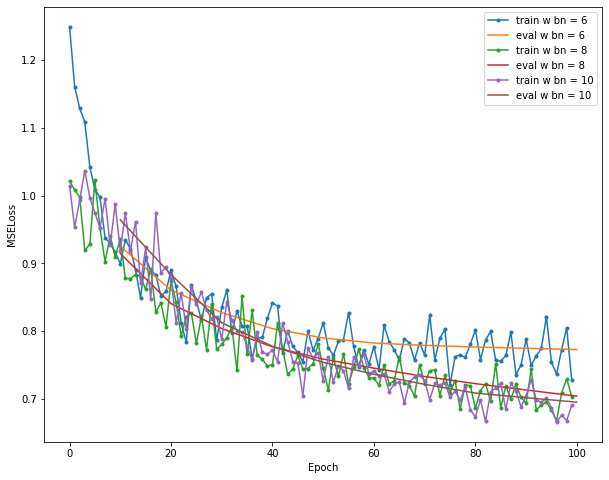

In [0]:
import itertools

tr_losses = []
te_losses = []
model = []
for i in range(len(hparams['bottleneck_size'])):

  model.append(ConvAutoencoder((hparams['bottleneck_size'])[i]))
  tr_loss_i = []
  te_loss_i = []
  # specify loss function
  criterion = nn.MSELoss()

  # specify loss function
  optimizer = torch.optim.Adam(model[i].parameters(), lr=0.001)
 
  tr_loss_i, te_loss_i = train_net(model[i], train_loader, optimizer, hparams['num_epochs'], criterion, validation_loader,(hparams['bottleneck_size'])[i])
  tr_losses.append(np.asarray(list(itertools.chain.from_iterable(tr_loss_i))))
  te_losses.append(te_loss_i)
  
plt.figure(figsize=(10, 8))
plt.xlabel('Epoch')
plt.ylabel('MSELoss')

te_indexes = [ (len(train_dataset) / hparams['batch_size']) * (i+1) for i in range(hparams['num_epochs']) ]

for i in range(len(tr_losses)):
  plt.plot(tr_losses[i], '.-', label='train w bn = {}'.format((hparams['bottleneck_size'])[i]))
  plt.plot(te_indexes, te_losses[i], label='eval w bn = {}'.format((hparams['bottleneck_size'])[i]))
  plt.legend()


**4. Compute the avg. image reconstruction error (MSE) of the trained models on the MNIST validation and test sets.** 

In [0]:
test_err = []
val_err = []

print ("Bottleneck Size\t\tTest error(avg)\t\tValidation error(avg)")
print ("---------------------------------------------------------------------------")
for i in range(len(hparams['bottleneck_size'])):
  t_err = test_model(test_loader, model[i], criterion, hparams)
  test_err.append(t_err)
  v_err = test_model(validation_loader, model[i], criterion, hparams)
  val_err.append(v_err)
  print ("\t%d\t\t\t%f\t\t%f" % ((hparams['bottleneck_size'])[i], test_err[i], val_err[i]))

print ("---------------------------------------------------------------------------")

Bottleneck Size		Test error(avg)		Validation error(avg)
---------------------------------------------------------------------------
	6			0.767722		0.772942
	8			0.695536		0.704230
	10			0.683905		0.695364
---------------------------------------------------------------------------


**5. Select one of the autoencoders and feed it 5 random MNIST images from the test set.** Show them along with their reconstructions.

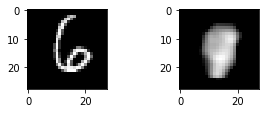

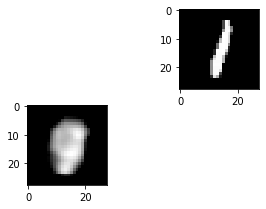

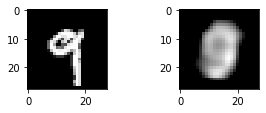

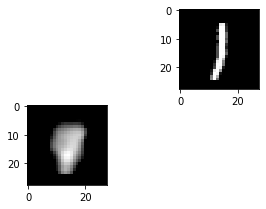

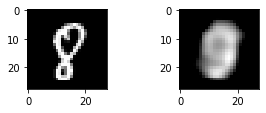

In [0]:
import random

test_subset_indexes = random.sample(range(1, 1000), 5)
test_subset = torch.utils.data.Subset(mnist_testset, test_subset_indexes)

loader = torch.utils.data.DataLoader(test_subset,
                                           batch_size=5, 
                                           shuffle = False)

# TODO: find best model
best_model = 0
for data in loader:
  img, _ = data
  #print(img[0][0][:][:])
  recon = model[best_model](img)

iterator = iter(loader)
img_orig, _ = iterator.next()
# We have to transform the image from tensor to numpy
img_orig = img_orig.numpy()

for i in range(5):
  digit_orig = np.squeeze(img_orig[i])
  fig = plt.figure(figsize = (5,5))
  ax = fig.add_subplot(3,2,i+1)

  ax.imshow(digit_orig, cmap = 'gray')

  ax = fig.add_subplot(3,2,i+2)
  ax.imshow(recon[i].detach().numpy()[0][:][:], cmap = 'gray')

**6. Generate 5 new images by injecting random values as input to the decoder. Show them.**

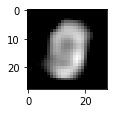

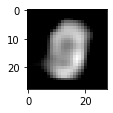

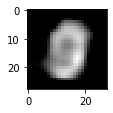

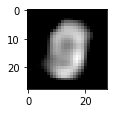

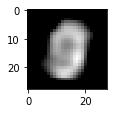

In [0]:
import torchvision

#rand_img = torch.rand(5, 1, 28, 28)
rand_img = torch.empty(5, 1, 28, 28).uniform_(-0.4242,2.8088)

# QUESTION: Normalize those data in the same way of MNIST?

#norm = torchvision.transforms.Normalize(mean= 0.1207, std= 0.3081)
#norm = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

#for img in rand_img:
#for i in range(5):
#  rand_img[i][0][:][:] = norm(torch.Tensor(rand_img[i][0][:][:]))

loader = torch.utils.data.DataLoader(rand_img, batch_size=5, shuffle = False)

for data in loader:
  rand_recon = model[best_model](data)

for i in range(5):
  fig = plt.figure(figsize = (5,5))
  ax = fig.add_subplot(3,2,i+1)

  ax.imshow(digit_orig, cmap = 'gray')

  ax.imshow(rand_recon[i].detach().numpy()[0][:][:], cmap = 'gray')

# Ex 2: Transfer Learning
Idea: reuse autoencoder weights for pre-training and fine-tuning of a
classifier trained on a small labeled subset of MNIST.

Steps:
1. Select a subset of 100 images and their associated labels from the MNIST training data.
2. Select one of the previously trained autoencoders.
3. Create a digit (0-9) classification model reusing the encoder of the autoencoder and adding
the needed fully connected (projection) layer.
4. Pre-training: use the weights of the autoencoder as initial values for the network weights and
train a classification model on the subset of 100 samples.
5. Fine-tuning: do the same, but train the new projection layer with a normal learning rate and
the reused part with a very low learning rate.
6. From scratch: train the model on the 100 samples without reusing the decoder weights at all.
7. Show the accuracy of the four models on the MNIST test set in a table.

**1. Select a subset of 100 images and their associated labels from the MNIST training data**

In [0]:
train_subset_indexes = random.sample(range(1, len(mnist_testset)), 95)
train_subset = torch.utils.data.Subset(mnist_trainset, train_subset_indexes)

train_loader_100 = torch.utils.data.DataLoader(train_subset,batch_size=1,shuffle = False)

val_subset_indexes = random.sample(range(1, len(mnist_testset)), 5)
val_subset = torch.utils.data.Subset(mnist_trainset, val_subset_indexes)

val_loader_100 = torch.utils.data.DataLoader(val_subset,batch_size=1,shuffle = False)

**2. Select one of the previously trained autoencoders**

In [0]:
pretrained_model = model[0]


**3. Create a digit (0-9) classification model reusing the encoder of the autoencoder and adding
the needed fully connected (projection) layer.**

In [0]:
classifier_pret = nn.Sequential(
    pretrained_model.encoder,
    nn.Linear( (hparams['bottleneck_size'])[0], 10 ),
    nn.LogSoftmax()
)


**4. Pre-Training**

In [0]:
# Let's define some hyper-parameters
hparams = {
    'batch_size':10,
    'num_epochs':10,
    'test_batch_size':64,
    'hidden_size':128,
    'num_classes':10,
    'num_inputs':784,
    'learning_rate':1e-3,
    'log_interval':100,
    'bottleneck_size': [6, 8, 10]
}

for layer in classifier_pret[:-2]:
  for param in layer.parameters():
      param.requires_grad = False

# specify loss function
criterion = nn.NLLLoss()

# specify loss function
optimizer = torch.optim.Adam(classifier_pret.parameters(), lr=0.001)

loss = train_net(classifier_pret, train_loader_100, optimizer, hparams['num_epochs'], criterion, val_loader_100, autoenc=False)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 1 [95/95 (100%)]	Loss: 6.375085	
Eval set: Average loss: 2.3424
Train Epoch: 2 [95/95 (100%)]	Loss: 5.707025	
Eval set: Average loss: 2.2459
Train Epoch: 3 [95/95 (100%)]	Loss: 5.117338	
Eval set: Average loss: 2.1922
Train Epoch: 4 [95/95 (100%)]	Loss: 4.591182	
Eval set: Average loss: 2.1664
Train Epoch: 5 [95/95 (100%)]	Loss: 4.120226	
Eval set: Average loss: 2.1582
Train Epoch: 6 [95/95 (100%)]	Loss: 3.701759	
Eval set: Average loss: 2.1611
Train Epoch: 7 [95/95 (100%)]	Loss: 3.335526	
Eval set: Average loss: 2.1707
Train Epoch: 8 [95/95 (100%)]	Loss: 3.021430	
Eval set: Average loss: 2.1839
Train Epoch: 9 [95/95 (100%)]	Loss: 2.758351	
Eval set: Average loss: 2.1985
Train Epoch: 10 [95/95 (100%)]	Loss: 2.543508	
Eval set: Average loss: 2.2131


**5. Fine-tuning**

In [0]:
classifier_fine = nn.Sequential(
    pretrained_model.encoder,
    nn.Linear( (hparams['bottleneck_size'])[0], 10 ),
    nn.LogSoftmax()
)


In [0]:
# specify loss function
criterion = nn.NLLLoss()

# specify loss function

# QUESTION: specify different lr? (not clear in https://pytorch.org/docs/stable/optim.html)
optimizer = torch.optim.Adam(
   [ { 'params': classifier_fine[0].parameters(), 'lr':1e-5 } ],
   lr=1e-3
   )


loss = train_net(classifier_fine, train_loader, optimizer, hparams['num_epochs'], criterion, val_loader_100, autoenc=False)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 1 [600/600 (100%)]	Loss: 3.588070	
Eval set: Average loss: 3.1457
Train Epoch: 2 [600/600 (100%)]	Loss: 3.664886	
Eval set: Average loss: 3.1457
Train Epoch: 3 [600/600 (100%)]	Loss: 3.814653	
Eval set: Average loss: 3.1457
Train Epoch: 4 [600/600 (100%)]	Loss: 4.169481	
Eval set: Average loss: 3.1457
Train Epoch: 5 [600/600 (100%)]	Loss: 3.484479	
Eval set: Average loss: 3.1457
Train Epoch: 6 [600/600 (100%)]	Loss: 3.559724	
Eval set: Average loss: 3.1457
Train Epoch: 7 [600/600 (100%)]	Loss: 3.894898	
Eval set: Average loss: 3.1457
Train Epoch: 8 [600/600 (100%)]	Loss: 3.963819	
Eval set: Average loss: 3.1457
Train Epoch: 9 [600/600 (100%)]	Loss: 3.752506	
Eval set: Average loss: 3.1457
Train Epoch: 10 [600/600 (100%)]	Loss: 3.282983	
Eval set: Average loss: 3.1457


**6. From Scratch**

In [0]:
untrained_model=ConvAutoencoder(6)

classifier_scratch = nn.Sequential(
    untrained_model.encoder,
    nn.Linear( (hparams['bottleneck_size'])[0], 10 ),
    nn.LogSoftmax()
)

# specify loss function
criterion = nn.NLLLoss()

# specify loss function
optimizer = torch.optim.Adam(classifier_scratch.parameters(), lr=0.001)

loss = train_net(classifier_scratch, train_loader_100, optimizer, hparams['num_epochs'], criterion, val_loader_100, autoenc=False)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 1 [95/95 (100%)]	Loss: 2.228382	
Eval set: Average loss: 2.3339
Train Epoch: 2 [95/95 (100%)]	Loss: 0.758102	
Eval set: Average loss: 2.1596
Train Epoch: 3 [95/95 (100%)]	Loss: 0.651927	
Eval set: Average loss: 1.8700
Train Epoch: 4 [95/95 (100%)]	Loss: 0.474205	
Eval set: Average loss: 1.7757
Train Epoch: 5 [95/95 (100%)]	Loss: 0.354990	
Eval set: Average loss: 1.7962
Train Epoch: 6 [95/95 (100%)]	Loss: 1.168533	
Eval set: Average loss: 2.0843
Train Epoch: 7 [95/95 (100%)]	Loss: 0.238947	
Eval set: Average loss: 1.7072
Train Epoch: 8 [95/95 (100%)]	Loss: 1.919726	
Eval set: Average loss: 2.1491
Train Epoch: 9 [95/95 (100%)]	Loss: 0.214706	
Eval set: Average loss: 2.1096
Train Epoch: 10 [95/95 (100%)]	Loss: 0.056245	
Eval set: Average loss: 1.4984


# Ex 3 - Optional Exercise A: Variational Autoencoder

Idea: turn the autoencoder from Exercise 1 into a variational autoencoder.

Steps:
1. Implement an autoencoder like that from Exercise 1, but turning the deterministic
bottleneck into a stochastic bottleneck, with an isotropic Gaussian as distribution for the
latent variables.
2. Train the model optimizing the Evidence Lower Bound (ELBO).
3. Generate samples with the decoder and show them.

# Ex 4 - Optional Exercise B: Conditional GAN

Idea: train a condition la Generative Adversarial Network (GAN) to generate digit images based on the given number.
Note: you can use as starting point the lab about GANs.

Steps:
1. Implement a generator and discriminator based con deconvolutions and convolutions
respectively.
2. Train the GAN on MNIST.
3. Generate samples with the generator and show them.

In [0]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets, utils
from IPython.display import display
from PIL import Image
import numpy as np
import math

## Utils
Some utils with minor importance

In [0]:
def norm_noise(size):
    return torch.cuda.FloatTensor(size, 100).normal_()
  
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)
  
def display_batch_images(img, imtype=np.uint8, unnormalize=True, nrows=None, mean=0.5, std=0.5):
    # select a sample or create grid if img is a batch
    if len(img.shape) == 4:
        nrows = nrows if nrows is not None else int(math.sqrt(img.size(0)))
        img = utils.make_grid(img, nrow=nrows)

    # unnormalize
    img = img.cpu().float()
    img = (img*std+mean)*255

    # to numpy
    image_numpy = img.numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    display(Image.fromarray(image_numpy.astype(imtype))) 

## Dataset
Download and prepare dataset


In [0]:
def mnist():
    tf = transforms.Compose(
        [
            transforms.Resize(32, interpolation=0),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (.5,))
        ])
    return datasets.MNIST(root='./data/', train=True, transform=tf, download=True)

## Data Loader
Create a data loader for the MNIST dataset

In [0]:
batch_size = 100
data_loader = torch.utils.data.DataLoader(mnist(), batch_size=batch_size, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:02, 3696048.37it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 57415.49it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:01, 876750.70it/s]                             
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 21349.63it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


## Networks
First, lets define our simple generator

In [0]:
class Generator(torch.nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()

        self.emb = nn.Embedding(10, 10)
      
        self._fc = torch.nn.Linear(110, 1024*4*4)

        self._conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self._conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self._conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=1, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.Tanh()
        )

    def forward(self, x, labels):
        
        # Composition of noise and label embedding
        # x = x.view(x.size(0), 100)
        c = self.emb(labels)
        x = torch.cat([x, torch.FloatTensor(c)], 0)
        
        # Noise to image
        x = self._fc(x)
        x = self._conv1(x.view(x.shape[0], 1024, 4, 4))
        x = self._conv2(x)
        return self._conv3(x)

Similarly lets define a simple discriminator

In [0]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()

        self.emb = nn.Embedding(10, 10)
        
        self._conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self._fc = nn.Sequential(
            nn.Linear(512*4*4, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        
        # Composition of noise and label embedding
        # x = x.view(x.size(0), -1)
        c = self.emb(labels)
        x = torch.cat([x, torch.FloatTensor(c)], 0)
        
        # Classify image as fake or real
        x = self._conv1(x)
        x = self._conv2(x)
        x = self._conv3(x)
        return self._fc(x.view(-1, 512*4*4))

## Model
Now lets create the core of our task, the model.  Remember GANs loss:

$\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]$

In [0]:
class Model:
    # --------------------------
    # -- PREPARE MODEL
    # --------------------------
    
    def __init__(self, batch_size):
        self._create_networks()
        self._create_optimizer()
        self._init_criterion(batch_size)
        
    def _create_networks(self):
        # create networks
        self._generator = Generator()
        self._discriminator = Discriminator()
        
        # init weights
        self._generator.apply(init_weights)
        self._discriminator.apply(init_weights)
        
        # move to cuda
        self._generator.cuda()
        self._discriminator.cuda()
        
    def _create_optimizer(self):
        # generator optimizer
        self._opt_g = torch.optim.Adam(self._generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        # discriminator optimizer
        self._opt_d = torch.optim.Adam(self._discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
    def _init_criterion(self, batch_size):
        self._criterion = nn.BCELoss()
        self._label_real = Variable(torch.ones(batch_size, 1)).cuda()
        self._label_fake = Variable(torch.zeros(batch_size, 1)).cuda()
        
    # --------------------------
    # -- Generate Fake Samples
    # --------------------------
    
    # TODO: probable problem here, putting random noise with random labels!
    def generate_samples(self, batch_size, z=None, labels=None):
        # sample random noise
        if z is None:
            z = norm_noise(batch_size)
        if labels is None:
            labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
            
        # TODO: generate fake samples out of the random noise z
        fake_samples = self._generator(z, labels)
        return fake_samples
    
    # --------------------------
    # -- Optimize Model
    # --------------------------
        
    def step_optimization(self, real_samples, real_labels):
        # generate fake labels
        fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, real_samples.size(0)))).cuda()
        # generate fake samples
        fake_samples = self.generate_samples(real_samples.size(0), fake_labels)
        
        # optimize generator
        loss_g = self._step_opt_g(fake_samples, fake_labels)
        
        # optimize discriminator
        loss_d = self._step_opt_d(real_samples, real_labels, fake_samples.detach(), fake_labels)
        
        return loss_g, loss_d
      
    def _step_opt_g(self, fake_samples, fake_labels):
        # Reset gradients
        self._opt_g.zero_grad()
        
        # Calculate generator loss
        estim_fake = self._discriminator(fake_samples, fake_labels)
        loss = self._criterion(estim_fake, self._label_real)
        loss.backward()
        
        # Update weights
        self._opt_g.step()
        
        return loss.item()
        
    def _step_opt_d(self, real_samples, real_labels, fake_samples, fake_labels):
        # Reset gradients
        self._opt_d.zero_grad()

        # Calculate discriminator loss for real samples
        estim_real = self._discriminator(real_samples, real_labels)
        loss_real = self._criterion(estim_real, self._label_real)

        # Calculate discriminator loss for fake samples
        estim_fake = self._discriminator(fake_samples, fake_labels)
        loss_fake = self._criterion(estim_fake, self._label_fake)
        
        # Total discriminator loss
        loss = (loss_real + loss_fake) / 2
        loss.backward()

        # Update weights
        self._opt_d.step()

        return loss_real.item(), loss_fake.item()
        
  

## Train

In [0]:
num_epochs = 3
num_val_samples = 10
z_val = norm_noise(num_val_samples)
model = Model(batch_size)

In [0]:
# THIS BLOCK KEEPS CRASHING (NO ERROR REPORT)

for epoch in range(num_epochs):
  
    # Train epoch
    for n_batch, (real_samples, real_labels) in enumerate(data_loader):
        
        # Prepare batch data
        real_samples = Variable(real_samples).cuda()
        real_labels = Variable(real_labels).cuda()
          
        # Update model weights
        loss_g, loss_d = model.step_optimization(real_samples, real_labels)
        
        # Show current loss
        if (n_batch) % 10 == 0:
            print(f"epoch: {epoch}/{num_epochs}, batch: {n_batch}/{len(data_loader)}, G_loss: {loss_g}, D_loss: {loss_d}")    
          
        # Show fake samples
        if (n_batch) % 100 == 0:
            val_fake_samples = model.generate_samples(num_val_samples, z=z_val, labels=torch.FloatTensor(np.arange(9)).cuda()).data.cpu()
            display_batch_images(val_fake_samples)